In [1]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Setup ImageDataGenerator dengan augmentasi lebih agresif
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_dir = '/kaggle/input/bdc-unhas/train'  # Ganti dengan path dataset pelatihan
val_dir = '/kaggle/input/bdc-unhas/val'  # Ganti dengan path dataset validasi

In [3]:
# Setup Stratified K-Fold Validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

In [4]:
# Load VGG16 tanpa fully connected layer
base_model = VGG16(weights='/kaggle/input/vgg16-v3/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Bekukan layer awal terlebih dahulu
for layer in base_model.layers:
    layer.trainable = False

# Menambahkan lapisan baru untuk klasifikasi dua kelas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [5]:
# Compile model tahap awal
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Training tahap 1 (freeze seluruh base model)
history_pre_finetune = model.fit(
    train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=True),
    epochs=10,
    validation_data=val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 787ms/step - accuracy: 0.5405 - loss: 1.5340 - val_accuracy: 0.9300 - val_loss: 1.3202 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 480ms/step - accuracy: 0.6719 - loss: 1.3402 - val_accuracy: 0.9050 - val_loss: 1.1062 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 480ms/step - accuracy: 0.8303 - loss: 1.1346 - val_accuracy: 0.8900 - val_loss: 0.9319 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 475ms/step - accuracy: 0.8793 - loss: 0.9607 - val_accuracy: 0.9050 - val_loss: 0.8147 - learning_rate: 1.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 479ms/step - accuracy: 0.8991 - loss: 0.8347 - val_accuracy: 0.9400 - val_loss: 0.6995 - learning_rate: 1.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.8981 - loss: 0.7697 - val_accuracy: 0.9075 - val_loss: 0.6996 - learning_rate: 1.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 479ms/step - accuracy: 0.91

In [6]:
# Unfreeze beberapa layer terakhir setelah model stabil
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Gunakan learning rate lebih kecil untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Training tahap 2 (fine-tuning hanya pada layer terakhir yang di-unfreeze)
history_finetune = model.fit(
    train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=True),
    epochs=20,
    validation_data=val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 525ms/step - accuracy: 0.9550 - loss: 0.4911 - val_accuracy: 0.9600 - val_loss: 0.4596 - learning_rate: 1.0000e-05
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 501ms/step - accuracy: 0.9783 - loss: 0.4074 - val_accuracy: 0.9900 - val_loss: 0.4060 - learning_rate: 1.0000e-05
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 476ms/step - accuracy: 0.9819 - loss: 0.4103 - val_accuracy: 0.9775 - val_loss: 0.4283 - learning_rate: 1.0000e-05
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 477ms/step - accuracy: 0.9835 - loss: 0.3882 - val_accuracy: 0.9850 - val_loss: 0.4080 - learning_rate: 1.0000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.9815 - loss: 0.3882 - val_accuracy: 0.9875 - val_loss: 0.3935 - learning_rate: 1.0000e-05
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 481ms/step - accuracy: 0.9856 - loss: 0.3815 - val_accuracy: 0.9850 - val_loss: 0.4099 - l

In [7]:
# Evaluasi model dengan confusion matrix dan classification report
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)
predictions = model.predict(val_generator)
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = val_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report(true_classes, predicted_classes)}")

Found 400 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
Confusion Matrix:
[[196   4]
 [  1 199]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       200
           1       0.98      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [8]:
# Menghitung akurasi dan metrik lainnya
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Akurasi pada data validasi: {accuracy * 100:.2f}%')

# Print classification report dan confusion matrix untuk metrik lebih detail
print(classification_report(true_classes, predicted_classes))
print(confusion_matrix(true_classes, predicted_classes))

Akurasi pada data validasi: 98.75%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       200
           1       0.98      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

[[196   4]
 [  1 199]]


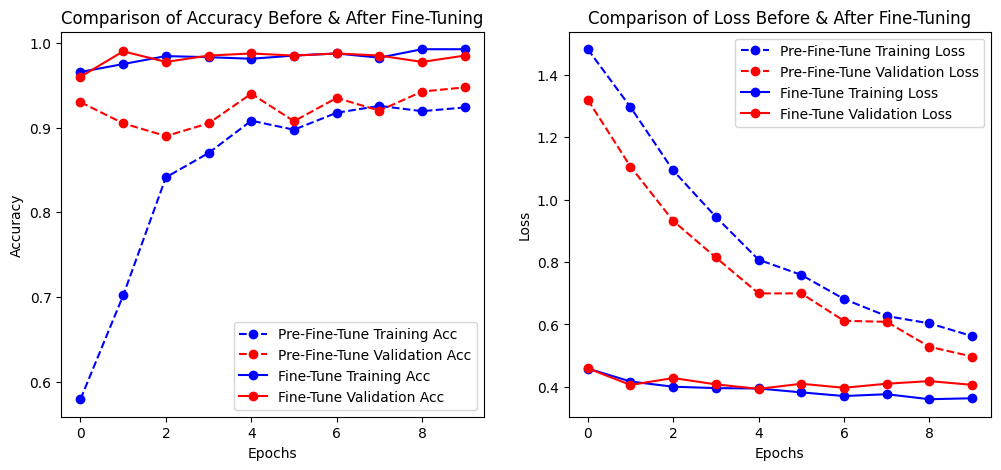

In [9]:
# Plot perbandingan hasil sebelum & sesudah fine-tuning
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_pre_finetune.history['accuracy'], 'bo--', label='Pre-Fine-Tune Training Acc')
plt.plot(history_pre_finetune.history['val_accuracy'], 'ro--', label='Pre-Fine-Tune Validation Acc')
plt.plot(history_finetune.history['accuracy'], 'bo-', label='Fine-Tune Training Acc')
plt.plot(history_finetune.history['val_accuracy'], 'ro-', label='Fine-Tune Validation Acc')
plt.title('Comparison of Accuracy Before & After Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_pre_finetune.history['loss'], 'bo--', label='Pre-Fine-Tune Training Loss')
plt.plot(history_pre_finetune.history['val_loss'], 'ro--', label='Pre-Fine-Tune Validation Loss')
plt.plot(history_finetune.history['loss'], 'bo-', label='Fine-Tune Training Loss')
plt.plot(history_finetune.history['val_loss'], 'ro-', label='Fine-Tune Validation Loss')
plt.title('Comparison of Loss Before & After Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke dataset test
test_dir = "/kaggle/input/bdc-unhas/Test"

# Data augmentation untuk set test (hanya rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Menyiapkan daftar gambar yang akan diprediksi
test_images = []
filenames = []

# Pemetaan kelas numerik ke nama kelas
class_labels = {0: 'covid', 1: 'normal'}

# Loop untuk membaca gambar dalam folder test
# Mengurutkan file berdasarkan nama
for filename in sorted(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, filename)
    
    if os.path.isfile(img_path):
        # Menyimpan nama file gambar
        filenames.append(filename)

        # Memuat dan mempersiapkan gambar untuk prediksi
        img = image.load_img(img_path, target_size=(224, 224))  # Ukuran yang sesuai dengan model (224x224)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
        test_images.append(img_array)

# Mengonversi list gambar menjadi array NumPy
test_images = np.vstack(test_images)

# Lakukan prediksi menggunakan model yang telah dimuat
predictions = model.predict(test_images)

# Mengambil kelas dengan probabilitas tertinggi
predicted_classes = (predictions > 0.5).astype("int32")  # Gunakan threshold 0.5 untuk klasifikasi biner

# Mengonversi hasil numerik ke nama kelas
predicted_class_names = [class_labels[class_idx] for class_idx in predicted_classes.flatten()]

# Membuat DataFrame untuk hasil prediksi
results = pd.DataFrame({
    'Filename': filenames,
    'Predicted Class': predicted_class_names
})

# Menyimpan DataFrame ke dalam Excel
output_file = 'Template_Jawaban_Penyisihan_v4.xlsx'
results.to_excel(output_file, index=False, engine='openpyxl')

print(f'Hasil prediksi disimpan di {output_file}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step
Hasil prediksi disimpan di Template_Jawaban_Penyisihan_v4.xlsx


In [11]:
# Simpan model

# uncomment ini untuk menyimpan model
model.save('tf_learning_with_vgg16.h5') 